In [2]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import GoogleGenerativeAI, GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage, ToolMessage, AIMessage
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers.string import StrOutputParser
from langchain_core.output_parsers import BaseOutputParser
from langchain_core.runnables import chain
from langchain_core.documents import Document
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from pydantic import BaseModel
from typing import Annotated, List, Sequence, Optional
from typing_extensions import TypedDict
from langchain_text_splitters import RecursiveCharacterTextSplitter
import bs4
from dotenv import load_dotenv
import os


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
load_dotenv(".env")
GG_API_KEY = os.environ.get('GOOGLE_API_KEY')
PINECONE_API_KEY = os.environ.get('PINECONE_API_KEY')
LANGSMITH_API_KEY = os.environ.get('LANGSMITH_API_KEY')


In [3]:
loader = WebBaseLoader(
    web_path="https://lilianweng.github.io/posts/2023-06-23-agent/",
    bs_kwargs={'parse_only' : bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))}
)
docs = loader.load()

# Split documents

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [4]:
# Set up vector database

import time
import os
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore


pc = Pinecone(api_key=PINECONE_API_KEY)

index_name = "ragfinance"  # change if desired

existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=768,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
        deletion_protection="enabled",  # Defaults to "disabled"
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)
vector_store = PineconeVectorStore(index=index, embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001"))

/Users/mac/Desktop/Code/Personal_Project/DeepLearningProject/RAG_Project/rag_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
vector_store.delete(delete_all=True)

In [ ]:
_ = vector_store.add_documents(all_splits)

In [11]:
modules = []
for f in os.listdir('finance_dataset'):
    if f.endswith('tsv'):
        python_module = f.split("_")[0] + "Task.py"
        modules.append(python_module)
for module in modules:
    print(module, end = " ")


MultiHeirttTask.py FinQATask.py FinanceBenchTask.py ConvFinQATask.py FinQABenchTask.py TATQATask.py FinDERTask.py 

In [ ]:
vector_store.similarity_search_with_score("task-decompositoin",)

[(Document(id='d4aa10922', metadata={'dataset_name': 'finqabench'}, page_content=' 2031 Notes).\n7'),
  0.562556505),
 (Document(id='d4aa1b854', metadata={'dataset_name': 'finqabench'}, page_content='• in the case of the 2018 Indenture, to add to, change or eliminate any of the provisions of the 2018 Indenture in respect of one or more series of debt securities; provided that any such addition, change or elimination shall become effective only when there is no outstanding security of any series created prior to the execution of such supplemental indenture that is entitled to the benefit of such provision and as to which such supplemental indenture would apply; • to cure any ambiguity, omission, defect or inconsistency; • to change any other provision; provided that the change does not adversely affect the interests of the holders of debt securities of, in the case of the 2013 Indenture any series, and in the case of the 2018 Indenture, any outstanding series, in any material respect; •

In [4]:
llm = ChatGoogleGenerativeAI(model = "gemini-2.0-flash")

In [5]:
@chain
def retriever(query : str) -> List[Document]:
    retrieved_docs = vector_store.similarity_search(query = query, k = 4)
    return retrieved_docs
retriever.invoke("helo")

[Document(id='1fb679d5-a736-4ce9-9766-d8f933a1e5b6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='GOALS:\n\n1. {{user-provided goal 1}}\n2. {{user-provided goal 2}}\n3. ...\n4. ...\n5. ...\n\nConstraints:\n1. ~4000 word limit for short term memory. Your short term memory is short, so immediately save important information to files.\n2. If you are unsure how you previously did something or want to recall past events, thinking about similar events will help you remember.\n3. No user assistance\n4. Exclusively use the commands listed in double quotes e.g. "command name"\n5. Use subprocesses for commands that will not terminate within a few minutes'),
 Document(id='cbf3a36b-5718-4c95-8730-5b4eec1ff508', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='HNSW (Hierarchical Navigable Small World): It is inspired by the idea of small world networks where most nodes can be reached by any other nodes within a 

In [33]:
user_query = "your search query here"
retrieved_documents = retriever(user_query)
print(retrieved_documents)


[Document(id='cbf3a36b-5718-4c95-8730-5b4eec1ff508', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='HNSW (Hierarchical Navigable Small World): It is inspired by the idea of small world networks where most nodes can be reached by any other nodes within a small number of steps; e.g. “six degrees of separation” feature of social networks. HNSW builds hierarchical layers of these small-world graphs, where the bottom layers contain the actual data points. The layers in the middle create shortcuts to speed up search. When performing a search, HNSW starts from a random node in the top layer and navigates towards the target. When it can’t get any closer, it moves down to the next layer, until it reaches the bottom layer. Each move in the upper layers can potentially cover a large distance in the data space, and each move in the lower layers refines the search quality.'), Document(id='7b6fdf31-ab24-44f3-96ed-c31a5ae62d5a', metadata={'source': 'https:/

In [6]:
QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five 
    different versions of the given user question to retrieve relevant documents from a vector 
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search. 
    Provide these alternative questions separated by newlines. Remember to provide questions only, no additional text!
    Original question: {question}""",
)
class ListOutputParser(BaseOutputParser):
    def parse(self, text : str) -> List[str]:
        lines = text.strip().split("\n")
        return list(filter(None, lines))
output_parser = ListOutputParser()
chain = QUERY_PROMPT | llm | output_parser
lines = chain.invoke({'question' : "What is task-decomposition?"})
lines

['How to break down a complex task?',
 'What are the methods for dividing a task into smaller subtasks?',
 'Explain the concept of task decomposition.',
 'What is the process of breaking down tasks into manageable parts?',
 'What are the benefits of using task decomposition techniques?']

In [7]:
def reciprocal_rank_fusion(results : List[List[Document]]) -> List[Document]:
    # docs_dict: key = doc_id, value = doc.page_content
    # rrf_score_dict : key = doc_id, value = score
    docs_dict, rrf_score_dict = {}, {}
    k = 60
    for query_docs in results:
        for rank, doc in enumerate(query_docs):
            docs_dict[doc.id] = doc
            rrf_score = 1 / (rank + 1 + k) # Calculatin reciprocal rank fusion score
            if (doc.id not in rrf_score_dict.keys()):
                rrf_score_dict[doc.id] = 0
            rrf_score_dict[doc.id] += rrf_score
    
    # Sort by rrf_score
    sorted_docs_by_rrf_score = sorted(rrf_score_dict.items(), key = lambda kv : kv[1], reverse = True)

    fusion_docs = []
    # Construct final document
    for doc_id, _ in sorted_docs_by_rrf_score:
        fusion_docs.append(docs_dict[doc_id])
    return fusion_docs

rag_fusion_chain = retriever.map() | reciprocal_rank_fusion
rag_fusion_chain.invoke(lines)



[Document(id='4cdf6d41-c363-4d86-befa-c9b5f4c9c08a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-f

In [ ]:
# Rerank document using cross-encoder



In [41]:
from langgraph.prebuilt import tools_condition

In [ ]:
system_message = "You are a helpful participant. Remember not to generate the answer in the markdown format!"
prompt = ChatPromptTemplate([
    ('system', system_message),
    MessagesPlaceholder('messages'),

]
)
runnable = prompt | llm
class State(TypedDict):
    messages : Annotated[Sequence[BaseMessage], add_messages]


# Defining tool for using RAG
@tool(response_format="content_and_artifact")
def retrieve(query):
    """Used to retrieve external knowledge when the 
    LLM doesn't know the exact answer (RAG)"""
    retrieved_docs = retriever.invoke(query)
    serialized_docs = "\n\n".join([docs.page_content for docs in retrieved_docs])
    return serialized_docs, retrieved_docs
 
tools = ToolNode(tools = [retrieve])

def query_or_respond(state : State):
    """Query for external knowledge or respond immediately"""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state['messages'])
    return {'messages' : [response]}

def router(state : State):
    last_message = state['messages'][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return 'tools'
    else:
        return END

# Create graph
def generate(state : State):
    # Only call this function when the previous message is tool message
    tool_messages = []
    messages = state['messages']
    for message in reversed(messages):
        if message.type == 'tool':
            tool_messages.append(message)
        else:
            break
    # Extract context from tool messages
    context = "\n\n".join([message.content for message in tool_messages])
    rag_prompt = f"""You are a question-answering assistent. If you don't know the answer, just
    say "I don't know". Otherwise, your answer should be relevant to the questions and concise. 
    Use this context to answer my question: {context}.
    """

    # Extract conversation messages only
    conversation_message = [message for message in messages if message.type in ('human', 'system')
                            or (message.type in 'ai' and not message.tool_calls)]
    final_messages = [SystemMessage(rag_prompt)] + conversation_message
    response = runnable.invoke(final_messages)
    return {'messages' : [response]}

workflow = StateGraph(State)
workflow.add_node(query_or_respond)
workflow.add_node(tools)
workflow.add_node(generate)


workflow.set_entry_point('query_or_respond')
workflow.add_conditional_edges('query_or_respond', path = router, path_map = {END : END, 'tools' : 'tools'})
workflow.add_edge('tools', 'generate')
workflow.add_edge('generate', END)
# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

app = workflow.compile()

            
        

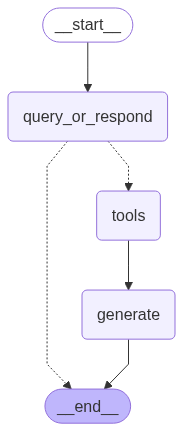

In [154]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable" : {'thread_id' : "12ab"}}


# Do normal chatflow
while(True):
    question = input("Question:")
    if question.lower() in ['exit', 'quit', 'break', 'out']:
        break
    print(f"Human: {question} \n")


    # Create streaming message 
    for message_chunk, metadata in app.stream(
        {'messages' : [HumanMessage(question)]}, stream_mode = 'messages', config = config
    ):

        if isinstance(message_chunk, AIMessage) and message_chunk.content:
            print(message_chunk.content, end = "", flush = True)

# Multiple query and RAG-Fusion

In [ ]:
# Generate multiple queries
# system_multiple_queries = """
# You are an excellent rephraser. You job is to generate 4 queries that have equivalent meaning to my original query.
# Remember to list the queries only, no external messages or any markdown format!
# """

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five 
    different versions of the given user question to retrieve relevant documents from a vector 
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search. 
    Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

chain = QUERY_PROMPT | llm 
result = chain.invoke({'question' : "What is task-decomposition?"})


In [ ]:
class ListOutputParser(BaseOutputParser):
    def parse(self, text : str) -> List[str]:
        lines = text.strip().split("\n")
        return list(filter(None, lines))
output_parser = ListOutputParser()
lines = output_parser.invoke(result)

In [27]:
new_retriever = retriever.map()

In [29]:
new_retriever.invoke(lines)

[[Document(id='e8c5ef63-cdfa-4cd1-ab93-810c333cc4db', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-

In [ ]:
# Create a RAG-fusion to fusion our documents
def rag_fusion(documents : List[List[Document]]) -> List[Document]:
    # documents_dict: key = id, value = document
    # RRF_score_dict: key = id, value = 
    pass